In [1]:
import numpy as np
import vtk
import matplotlib.pyplot as plt
import vtkplotlib as vpl
from vtk.util.numpy_support import vtk_to_numpy
import os
from scipy import spatial
from sklearn.decomposition import PCA


Bad key text.latex.preview in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to get an

In [2]:
def readfile(filename):
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def write_vtk(points, cell, filename):
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):

        # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()

def flatten(Shape):
    return np.concatenate((Shape[:, 0], Shape[:, 1], Shape[:, 2]))

def unflatten(Shape):
    n = len(Shape)//3
    return np.array([Shape[:n], Shape[n:2*n], Shape[2*n:]]).T

In [3]:
def Visualize(Faces_List=[], Wiring=[], colors=[], Scatter=[0]):
    mesh = Faces_List[0][Wiring][:, 1:]
    offset = np.zeros(mesh.shape)
    vpl.figure("Face")
    for i in range(len(Faces_List)) :
        mesh = Faces_List[i][Wiring][:, 1:] + offset
        vpl.mesh_plot(mesh, color=colors[i])
        offset[:, :, 0] += 0.01
    if Scatter[0]:
        vpl.scatter(Faces_List[0][Scatter], radius=0.0001, color='r')
    vpl.show()

In [4]:
from IPython.display import clear_output


def Construct_dataset(path) :
    L = os.listdir(path)
    Dataset = []
    for i in range(20) :
        if 'vtk' in L[i] :
            Tab, Tob = readfile(path+L[i])
            Dataset.append(flatten(Tob))

    return np.array(Dataset)

In [5]:
path = '../Aligned_data/'
Dataset = Construct_dataset(path)

In [6]:
L = os.listdir(path)
Tab, Tob = readfile(path+L[3])
Wiring = Tab

In [123]:
Train_data = Dataset[:9, :]
Test_data = Dataset[9:, :]

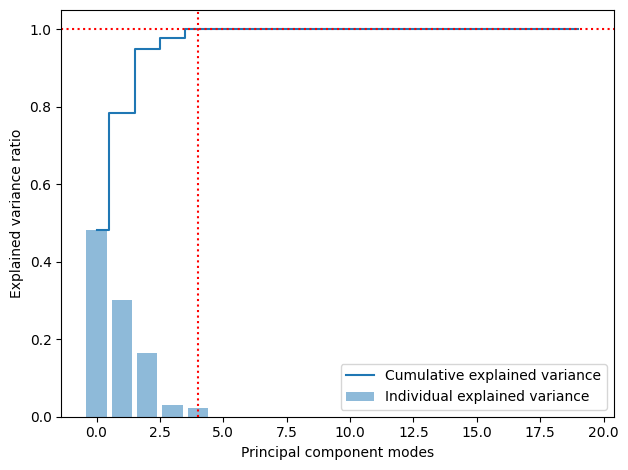

the number of significant PCA modes : 5


In [8]:
def PCA_analysis(data) :   
    pca = PCA(n_components=len(data))
    pca.fit(data)
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component modes')
    plt.legend(loc='best')
    plt.tight_layout()

    N = 0
    for i in range(len(cum_sum_eigenvalues)):
        if cum_sum_eigenvalues[i]>= 0.99*cum_sum_eigenvalues[-1] :
            plt.axhline(y = cum_sum_eigenvalues[i], color = 'r', linestyle = ':')
            plt.axvline(x = i, color = 'r', linestyle = ':')
            N = i+1
            break
    plt.show()
    print('the number of significant PCA modes : ' + str(N))

PCA_analysis(Dataset)

In [9]:
Visualize([unflatten(Train_data[i]) for i in range(Train_data.shape[0])], Wiring, ['w' for _ in range(Train_data.shape[0])])

In [43]:
from time import time 

def decompose(Shape, u):
        Coefs = np.zeros(u.shape[1])
        for i in range(u.shape[1]) :
            Coefs[i] = np.dot(Shape, u[:, i])/(np.linalg.norm(u[:, i]))**2
        return Coefs

def similarity(Model, Target, mean, u) :
    return 1 - (np.linalg.norm(decompose(Model, u)-Target)/np.linalg.norm(mean-Target))**2

def Reconstruct(Face, mean, Points, mean_dec, Dx1, Mx1, Mx2, u) :

    Face_c = Face-mean
    Target = decompose(Face, u)
    
    C_opt = Mx1 @ Face_c[Points]
    print(C_opt)
    Model = Mx2 @ C_opt + mean

    #for j in range(len(Points)//3) :
    #    Coords = Points[3*j:3*j+3]
    #    Copt = Dx1[j][0] @ (Face[Coords]- Model[Coords])
    #    Model += Dx1[j][1]  @ Copt 
    
    error = similarity(Model, Target, mean_dec, u)
    return Model, error


In [124]:
D = Train_data.shape[1]//3 
N = Train_data.shape[0]

Control_pts = np.random.randint(0, D, 20)
print(Control_pts[0])
#P = range(1, 5000, 100)

Visualize([unflatten(Train_data[0])], Wiring, ['w'], Control_pts)

31335


In [175]:
F = np.zeros(len(Control_pts)*3)

i = 0
while i < len(Control_pts) :
    F[3*i], F[3*i+1], F[3*i+2]= Control_pts[i], Control_pts[i]+D, Control_pts[i]+2*D
    i += 1

F = F.astype(int)

In [161]:
Train_data = Dataset[:6, :]
Test_data = Dataset[9:, :]

In [162]:
mean = np.mean(Train_data, axis=0)
X = (Train_data[:, :] - mean)
u, s, vh = np.linalg.svd(X.T, full_matrices=False)

#p = s.shape[0]
p=6
u = u[:, :p]
s = s[:p]
vh = vh[:p, :p]
u.shape, s.shape, vh.shape

((159447, 6), (6,), (6, 6))

In [163]:
X_new = u[F, :] @ np.diag(s)
u_new, s_new, vh_new = np.linalg.svd(X_new, full_matrices=False)
u_new.shape, s_new.shape, vh_new.shape

((60, 6), (6,), (6, 6))

In [164]:
from copy import deepcopy


Test = (np.min(Test_data)/600)*np.random.normal(0, 1, Test_data.shape) + Test_data
X_test = (deepcopy(Test) - mean).T
X_test.shape

X_test_n = deepcopy(Test).T

In [165]:
X_test.shape

(159447, 11)

In [170]:
F.shape

(60,)

[ 31335  84484 137633]
[  4378  57527 110676]
[ 27617  80766 133915]
[ 30248  83397 136546]
[ 47114 100263 153412]
[ 43402  96551 149700]
[ 33777  86926 140075]
[ 14114  67263 120412]
[ 29902  83051 136200]
[ 45625  98774 151923]
[ 39427  92576 145725]
[ 16232  69381 122530]
[ 17694  70843 123992]
[ 25130  78279 131428]
[ 29638  82787 135936]
[ 44862  98011 151160]
[ 19342  72491 125640]
[  4034  57183 110332]
[ 52099 105248 158397]
[ 20863  74012 127161]


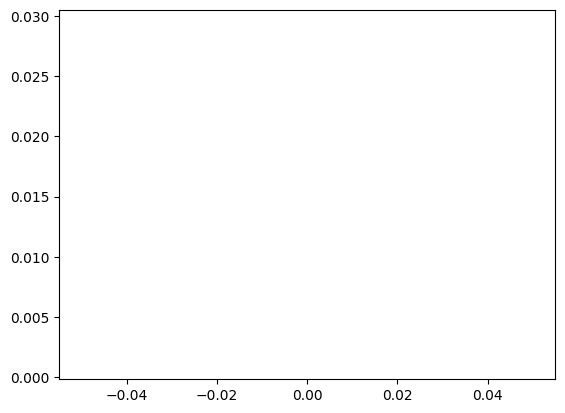

In [173]:
E = []
for i in range(0, 1) :

    error = []
    C_opt = vh_new.T @ np.diag(s_new/(s_new**2+0.00000001)) @ u_new.T @ X_test[F, i]
    Model = u @ np.diag(s) @ C_opt + mean
    Visualize([unflatten(X_test_n[:, i]), unflatten(mean), unflatten(Model)], Wiring, ['w', 'w', 'w'], Control_pts)


    Target = decompose(X_test_n[:, i], u)
    Mean_dec = decompose(mean, u)
    error.append(similarity(Model, Target, Mean_dec, u))
    

    for j in range(len(Control_pts)) :
        Coords = F[3*j:3*j+3]
        print(Coords)
        Copt = np.linalg.inv(u[Coords, :] @ np.diag(s) @ (u[Coords, :].T)) @ (X_test_n[:, i][Coords]- Model[Coords])
        Model += u @ np.diag(s) @ (u[Coords, :].T) @ Copt 

        error.append(similarity(Model, Target, Mean_dec, u))
    
    Visualize([unflatten(X_test_n[:, i]), unflatten(mean), unflatten(Model)], Wiring, ['w', 'w', 'w'], Control_pts)
    E.append(error)
    
E = np.array(E)    


plt.plot(-np.log(E))
plt.show()